In [1]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Conv2D,BatchNormalization,Lambda,Activation,Input,Flatten,Reshape,Conv2DTranspose,concatenate,Reshape,LeakyReLU

In [2]:
IMG_DIM = 28
DIM_S = 3
DIM_U = 10
supervised = True #False:Unsupervised
saved_path = ".\mnist_colored"
data = np.load(f"{saved_path}\colored_mnist.npz")

x_train = data['x_train']
x_train = x_train.astype(np.float32) / 255.0
u_train = data['y_train'] if supervised else x_train
s_train = data['s_train']

x_test = data['x_test']
x_test = x_test.astype(np.float32) / 255.0
u_test = data['y_test'] if supervised else x_test
s_test = data['s_test']




In [3]:
def one_hot(labels, num_labels):
    num_labels_data = labels.shape[0]
    one_hot_encoding = np.zeros((num_labels_data,num_labels))
    one_hot_encoding[np.arange(num_labels_data),labels] = 1
    one_hot_encoding = np.reshape(one_hot_encoding, [-1, num_labels])
    return one_hot_encoding

if supervised: u_train = one_hot(u_train, 10).astype(np.float32)
s_train = one_hot(s_train, 3).astype(np.float32)
if supervised: u_test = one_hot(u_test, 10).astype(np.float32)
s_test = one_hot(s_test, 3).astype(np.float32)

In [4]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
def get_encoder(DIM_Z, input_x):
    stride = 2
#     input_x = Input( shape = [IMG_DIM,IMG_DIM,3], name="x" )

    #first hidden layer
    x = Conv2D(64, 5, strides=stride, padding="same", name="enc_h1")(input_x)
    x = BatchNormalization(name="enc_h1_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h1_activation")(x)
    #second hidden layer
    x = Conv2D(128, 5, strides=stride, padding="same", name="enc_h2")(x)
    x = BatchNormalization(name="enc_h2_normalized")(x)
    x = Activation(LeakyReLU(), name="enc_h2_activation")(x)

    shape = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(DIM_Z*4, name="enc_dense_1")(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    z_mean = Dense(DIM_Z, name="z_mean")(x)
    z_log_sigma_sq = Dense(DIM_Z, name="z_sigma")(x)
    z = Lambda(sampling, output_shape=DIM_Z, name='z')([z_mean, z_log_sigma_sq])
    
#     prior_loss = K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
    
    encoder = Model(input_x, z, name = "Encoder")
#     encoder.add_loss((alpha+beta) * prior_loss)
    
    return (encoder, z_mean, z_log_sigma_sq)

In [6]:
def get_decoder(DIM_Z):
    stride = 2
    input_z = Input(shape = (DIM_Z,), name="z_encoder")
    input_s = Input( shape = (DIM_S,), name="s")
    z_with_s = concatenate([input_z, input_s], name="concat_layer")
    x = Dense(7*7*128, name="dec_dense_1")(z_with_s)
    x = BatchNormalization(name="dec_dense_1_normalized")(x)
    x = Activation(LeakyReLU(), name="dec_dense_1_activation")(x)

    #Unflatten
    x = Reshape((7,7,128), name="unflatten1")(x)
    x = BatchNormalization(name="unflatten1_normalized")(x)
    x = Activation(LeakyReLU(), name="unflatten1_activation")(x)

    x = Conv2DTranspose(64, 5, strides=stride, padding = "same", name="dec_h1")(x)
    x = BatchNormalization(name="dec_h1_normalized")(x)
    x = Activation(LeakyReLU(), name="dec_h1_activation")(x)

    x = Conv2DTranspose(3, 5, strides=stride, padding = "same", name="dec_h2")(x)
    x_hat = Activation('sigmoid', name="x_hat")(x)

    decoder = Model([input_z, input_s], x_hat, name = "Uncertainty_Decoder")
    return decoder

In [7]:
if supervised:
    def get_utility_model(DIM_Z):
        model = Sequential(name="Utility_Decoder_supervised")
        model.add(Dense(DIM_Z, input_dim=DIM_Z))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(DIM_U, activation='softmax', name="u_hat"))
        return model
else:
    def get_utility_model(DIM_Z):
        stride = 2
        model = Sequential(name="Utility_Decoder_unsupervised")
        model.add(Dense(7*7*128, input_dim=DIM_Z))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Reshape((7,7,128)))
        
        model.add(Conv2DTranspose(64, 5, strides=stride, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, 5, strides=stride, padding="same"))
        model.add(Activation("sigmoid"))
        return model

In [8]:
def get_z_discriminator(DIM_Z):
    model = Sequential(name="Latent_Space_Discriminator")
    
    model.add(Dense(128, input_dim=DIM_Z))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [9]:
def get_utility_discriminator():
    stride = 2
    model = Sequential(name="Attribute_Class_Discriminator")

    model.add(Dense(DIM_U * 4, input_dim=DIM_U))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(DIM_U * 4))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [10]:
def get_visible_space_discriminator():
    stride = 2
    model = Sequential(name="Visible_Space_Discriminator")
    
    model.add(Input(shape = [IMG_DIM,IMG_DIM,3]))
    
    model.add(Conv2D(32, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(64, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, 3, strides=stride, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1, activation="sigmoid"))
    return model

In [11]:
def get_prior_generator(DIM_Z, noise_dim=5):
    model = Sequential(name="Prior_Distribution_Generator")
    
    model.add(Dense(DIM_Z*4, input_dim=noise_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(DIM_Z*4))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(DIM_Z))
    
    return model

In [37]:
#Private Information Bottleneck framework
z_gen_enabled = False #if False, the algorithm sample prior from Normal Distribution
z_disc_enabled = False
u_disc_enabled = False

param = {
    "dimz": 16,
    "lambda" : 1.0,
    "gamma" : 0.9
}

## utility and reconstruction losses

if supervised:
    def loss_u(gamma):
        def loss(u_true, u_pred):
            return gamma * K.mean(K.sum(K.square(u_true-u_pred), axis=-1))
        return loss
else:
    def loss_u(gamma):
        def loss(u_true, u_pred):
            return gamma * K.mean(K.sum(K.square(u_true-u_pred), axis=(1,2,3)))
        return loss

def loss_x(lam):
    def loss(inp_x, out_x):
        return lam * K.mean(K.sum(K.square(inp_x-out_x), axis=(1,2,3)))
    return loss

bce = tf.keras.losses.BinaryCrossentropy()
# Weighted cross-entropy loss
def loss_wce(coef):
    def loss(y, y_pred):
         return coef * bce(y, y_pred)
    return loss

########## Inputs
learning_rate = 0.005
input_x = Input( shape=[IMG_DIM,IMG_DIM,3], name="x" )
input_s = Input( shape = (DIM_S,), name="s" )
input_z = Input( shape = (param["dimz"],), name="z" )
dim_noise = 5
input_noise = Input( shape = (dim_noise,), name="Noise")

########## Define AE: Encoder, Utility Decoder and Uncertainty Decoder
encoder,z_mean,z_log_sigma_sq = get_encoder(param["dimz"], input_x)
uncertainty_decoder = get_decoder(param["dimz"])
utility_decoder = get_utility_model(param["dimz"])

z = encoder(input_x)
x_hat = uncertainty_decoder([z, input_s])
u_hat = utility_decoder(z)

pib_autoencoder = Model([input_x, input_s], [x_hat, u_hat], name="PIB_Autoencoder")
prior_loss = (1+param["lambda"]) * K.mean(-0.5 * K.sum(1 + z_log_sigma_sq - K.square(z_mean) - K.exp(z_log_sigma_sq), axis=-1))
prior_loss = tf.identity(prior_loss, name="kl_loss")
pib_autoencoder.add_loss(prior_loss)
pib_autoencoder.compile(loss=[loss_x(param["lambda"]), loss_u(param["gamma"])], optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

########## Define Latent Space Discriminator
z_discriminator = get_z_discriminator(param["dimz"])
z_discriminator.compile(loss=loss_wce(1.0+param["lambda"]), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

##########
#z_discriminator should train separately
z_discriminator.trainable = False
prior_generator = get_prior_generator(param["dimz"])
prior_gen_zdiscriminator = Model(input_noise, z_discriminator(prior_generator(input_noise)), name="PIB_generator_zdiscriminator")
prior_gen_zdiscriminator.compile(loss=loss_wce(-1.0*(1+param["lambda"])), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

##########
encoder_zdiscriminator = Model(input_x, z_discriminator(encoder(input_x)), name="PIB_encoder_zdiscriminator")
encoder_zdiscriminator.compile(loss=loss_wce(-1.0*(1+param["lambda"])), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

##########
u_dircriminator = get_utility_discriminator() if supervised else get_visible_space_discriminator()
u_dircriminator.compile(loss=loss_wce(param["gamma"]), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

##########
#u_dircriminator should train separately
u_dircriminator.trainable = False

if z_gen_enabled:    
    decoder_udiscriminator = Model(input_noise, u_dircriminator(utility_decoder(prior_generator(input_noise))), name="PIB_decoder_discriminator")
else:
    decoder_udiscriminator = Model(input_z, u_dircriminator(utility_decoder(input_z)), name="PIB_decoder_discriminator")

decoder_udiscriminator.compile(loss=loss_wce(-1.0*param["gamma"]), optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

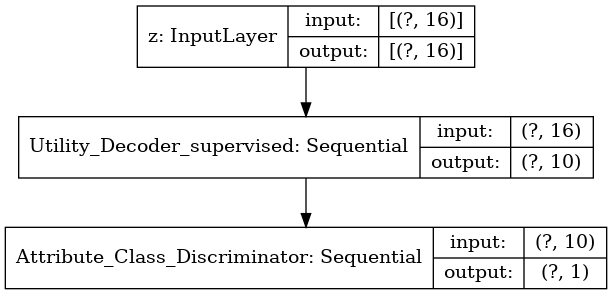

In [13]:
tf.keras.utils.plot_model(decoder_udiscriminator, show_shapes=True)

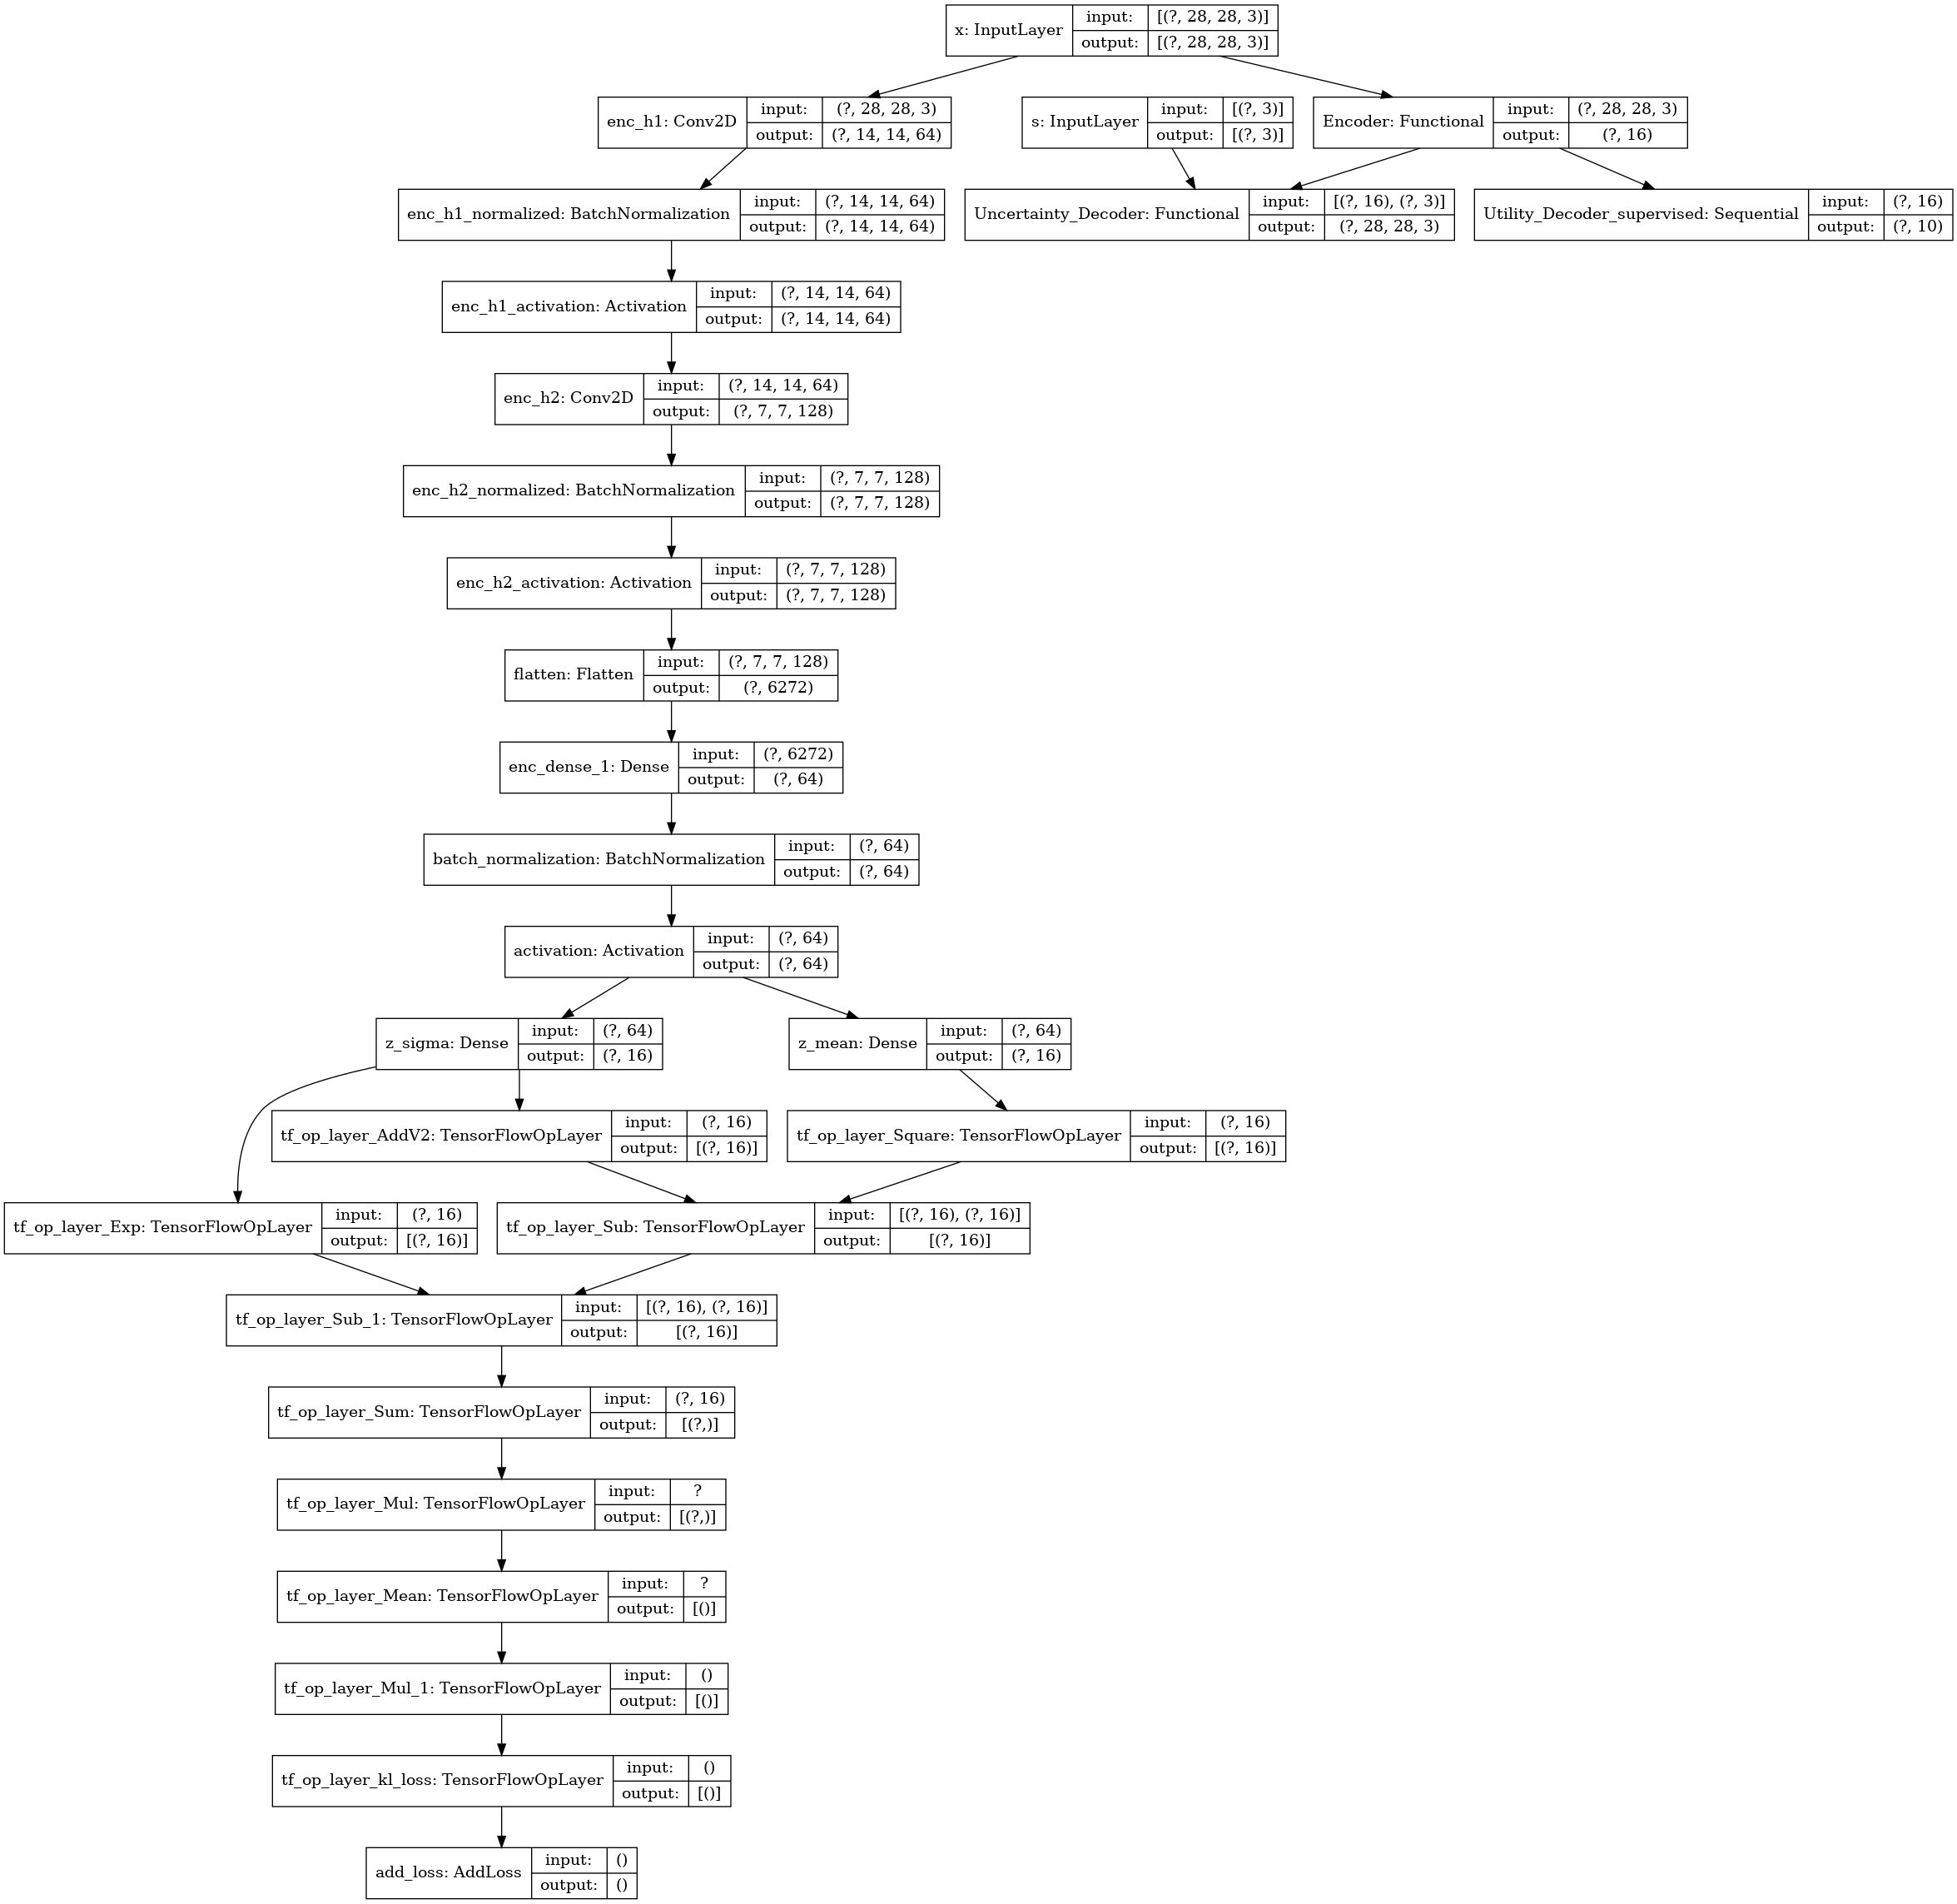

In [14]:
tf.keras.utils.plot_model(pib_autoencoder,show_shapes=True)

# Training

In [35]:
batch_size = 1024
max_itr = 1000

# Adversarial ground truths
ones = np.ones((batch_size, 1))
zeros = np.zeros((batch_size, 1))

# ones = tf.cast(ones, dtype=tf.float32)
# zeros = tf.cast(zeros, dtype=tf.float32)
# x_train = tf.convert_to_tensor(x_train)
# s_train = tf.convert_to_tensor(s_train)
# u_train = tf.convert_to_tensor(u_train)

In [16]:
print(sum([np.sum(w) for w in encoder.get_weights()]))

502.6648001074791


In [17]:
def sample_prior(latent_dim, batch_size):
    return np.random.normal(size=(batch_size, latent_dim))

In [39]:
start_time = time.time()
for epoch in range(max_itr):
    start_time_epoch = time.time()
    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    x = x_train[idx]
    s = s_train[idx]
    u = u_train[idx]

    # ---------------------
    #  1- Train the Encoder, Utility Decoder, Uncertainty Decoder
    # ---------------------
    ae_loss = pib_autoencoder.train_on_batch([x, s], [x, u])
    
    if z_disc_enabled:
    # ---------------------
    #  2- Train the Latent Space Discriminator
    # ---------------------

        if z_gen_enabled:
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
            latent_prior = prior_generator(noise)
        else:
            latent_prior = sample_prior(param["dimz"], batch_size)

        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x = x_train[idx]
        latent_enc = encoder(x)

        d_loss_prior = z_discriminator.train_on_batch(latent_prior, zeros)
        d_loss_enc = z_discriminator.train_on_batch(latent_enc, ones)
        dz_loss = 0.5 * np.add(d_loss_prior, d_loss_enc)

        # ---------------------
        # 3- Train the Encoder and Prior Distribution Generator Adversarially
        # ---------------------
        prior_loss = 0.
        if z_gen_enabled:
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
            prior_loss = prior_gen_zdiscriminator.train_on_batch(noise, zeros)

        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x = x_train[idx]
        edz_loss = encoder_zdiscriminator.train_on_batch(x, ones)
    else:
        dz_loss = 0
        prior_loss = 0
        edz_loss = 0
    
    if u_disc_enabled:
    # ---------------------
    #  4- Train Visible_Space/Attribute_Class Discriminator 
    # ---------------------
    
        if z_gen_enabled:
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
            latent = prior_generator(noise)
        else:
            latent = sample_prior(param["dimz"], batch_size)
        u_dec = utility_decoder(latent)

        idx = np.random.randint(0, x_train.shape[0], batch_size)
        u = u_train[idx]

        d_loss_real = u_dircriminator.train_on_batch(u, ones)
        d_loss_fake = u_dircriminator.train_on_batch(u_dec, zeros)
        du_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # ---------------------
    #  5- Train the Prior Distribution Generator and Utility Decoder Adversarially
    # ---------------------
        if z_gen_enabled:
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, dim_noise])
            gdu_loss = decoder_udiscriminator.train_on_batch(noise, zeros)
        else:    
            latent = sample_prior(param["dimz"], batch_size)
            gdu_loss = decoder_udiscriminator.train_on_batch(latent, zeros)
    else:
        gdu_loss = 0
        du_loss = 0
    
    
    # print losses (every 100th epoch)
    if epoch % 50 == 0:
        print(f"{epoch}, mse:{ae_loss[1]:.4f}, u:{ae_loss[2]:.4f}, dz:{dz_loss:.4f}, edz:{edz_loss:.4f}, prior:{prior_loss:.4f}, du:{du_loss:.4f}, gdu:{gdu_loss:.4f}")
        print(f"One epoch execution time: {(time.time() - start_time_epoch):.6} seconds")
        
total_time = (time.time() - start_time)
print(f"Total Execution Time: {total_time} seconds")

0, mse:601.3530, u:0.8526, dz:0.0000, edz:0.0000, prior:0.0000, du:0.0000, gdu:0.0000
One epoch execution time: 1.64616 seconds
50, mse:48.4685, u:0.7708, dz:0.0000, edz:0.0000, prior:0.0000, du:0.0000, gdu:0.0000
One epoch execution time: 0.0738397 seconds
100, mse:33.4027, u:0.5501, dz:0.0000, edz:0.0000, prior:0.0000, du:0.0000, gdu:0.0000
One epoch execution time: 0.0730844 seconds
150, mse:22.8355, u:0.3126, dz:0.0000, edz:0.0000, prior:0.0000, du:0.0000, gdu:0.0000
One epoch execution time: 0.0734234 seconds
200, mse:16.1656, u:0.1881, dz:0.0000, edz:0.0000, prior:0.0000, du:0.0000, gdu:0.0000
One epoch execution time: 0.0720944 seconds
250, mse:12.4778, u:0.1407, dz:0.0000, edz:0.0000, prior:0.0000, du:0.0000, gdu:0.0000
One epoch execution time: 0.071559 seconds
300, mse:11.5178, u:0.1154, dz:0.0000, edz:0.0000, prior:0.0000, du:0.0000, gdu:0.0000
One epoch execution time: 0.0716307 seconds
350, mse:10.3017, u:0.1121, dz:0.0000, edz:0.0000, prior:0.0000, du:0.0000, gdu:0.0000
O

In [19]:
def save_figures(pib):
    n_plot_samps = 10
    ind_list = [3, 2, 1, 18, 4 ,15, 11, 0, 128, 9]

    x_hat_no_color, *_ = pib.predict([x_test[ind_list], np.zeros((n_plot_samps,3)) ])
    x_hat_all_color, *_ = pib.predict([x_test[ind_list], np.ones((n_plot_samps,3)) ])
    s0 = np.zeros((n_plot_samps,3))
    s0[:, 0] = 1
    s1 = np.zeros((n_plot_samps,3))
    s1[:, 1] = 1
    s2 = np.zeros((n_plot_samps,3))
    s2[:, 2] = 1
    x_hat_0, *_ = pib.predict([x_test[ind_list], s0 ])
    x_hat_1, *_ = pib.predict([x_test[ind_list], s1 ])
    x_hat_2, *_ = pib.predict([x_test[ind_list], s2 ])
    ##
    ## plot first N
    ##

    from plot_tools import pics_tools as pic
    # plt.style.use('grayscale')

    fig = pic.plot_image_grid( \
      np.concatenate([x_test[ind_list], x_hat_no_color, x_hat_all_color, x_hat_0, x_hat_1, x_hat_2], axis=0),
      [IMG_DIM, IMG_DIM, 3], \
      (6,n_plot_samps) \
    )
    fig.set_size_inches(16.2, 10)
    plt.subplots_adjust(wspace=0, hspace=0)
#     plt.savefig(f'./saved_figures/colored_mnist_unblanced_{info_str}.eps', format='eps')
#     plt.savefig(f'./saved_figures/colored_mnist_unblanced_{info_str}.png', format='png')
    plt.show()

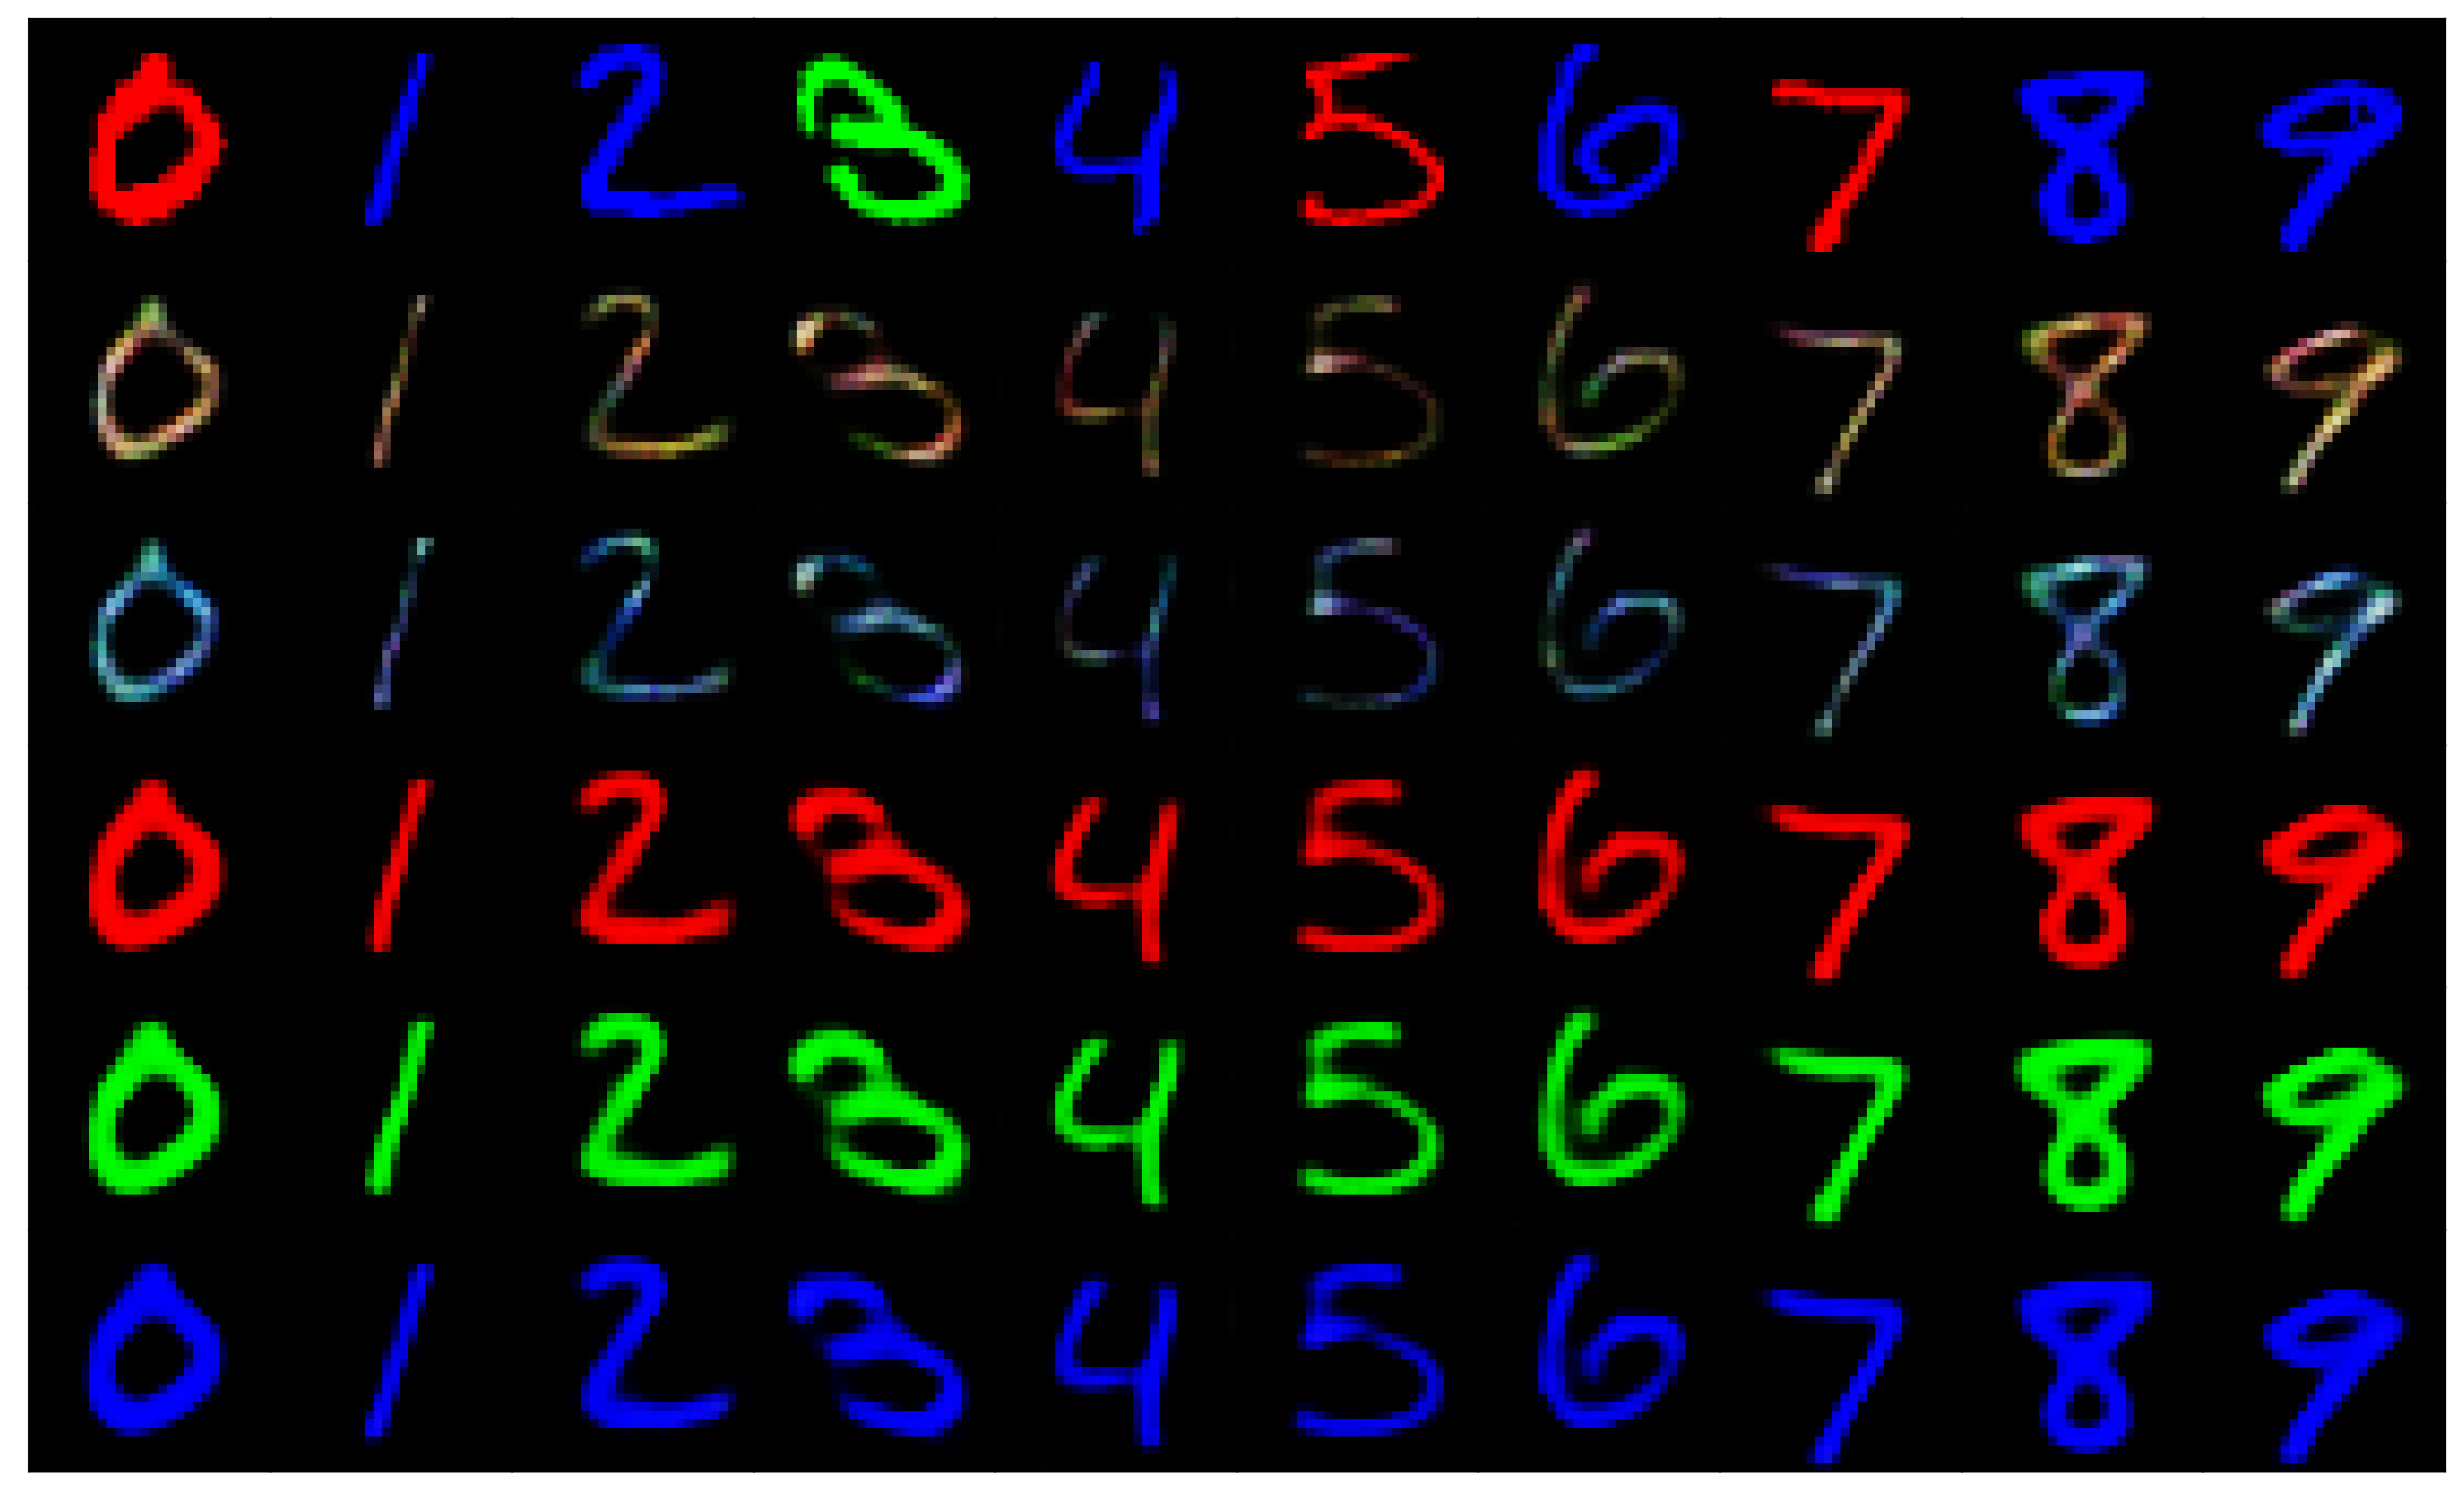

In [40]:
save_figures(pib_autoencoder)

In [41]:
_, u_test_hat = pib_autoencoder.predict([x_test, s_test])
np.mean(np.argmax(u_test_hat,axis=1)==np.argmax(u_test,axis=1)) * 100

95.13000000000001